In [8]:
import numpy as np
import matplotlib.pyplot as plt

Note: the module `pna` is where I am storing all the functions I write for this course.

# Question 1

First, define functions to calculate the coefficients of a polynomial interpolant constructed from monomial basis functions as well as a function to implement the Horner scheme.

In [4]:
from pna.interpolation import monomial_interpolant, honer_evaluate

%psource monomial_interpolant

def monomial_interpolant(f, nodes):
    """Construct a polynomial interpolant of the function f using monomial basis
    functions by sampling from f at the points given by nodes.

    Returns the coefficients of the polynomial and the condition number of the
    Vandermonde matrix.
    """
    f_nodes = f(nodes)
    V = np.vander(nodes, increasing=True)

    # compute coefficients
    a = np.linalg.solve(V, f_nodes)

    return a, np.linalg.cond(V)


In [5]:
%psource honer_evaluate

def honer_evaluate(a, x):
    """Evaluates the polynomial given by the coefficients a at points x using
    the Horner scheme"""
    b = a[-1]
    for a_n in a[-2::-1]:
        b = a_n + b * x
    return b


Second, define a function to implement the barycentric formula.

In [6]:
from pna.interpolation import barycentric_interpolate

%psource barycentric_interpolate

def barycentric_interpolate(f_i, x_i, x, chebyshev=False):
    """Constructs and evaluates a Lagrange interpolating polynomial."""
    if chebyshev:
        # For Chebyshev points we have an analytical formula for the weights
        weights = np.ones_like(x_i)
        weights[0] /= 2
        weights[-1] /= 2
        weights *= (-1) ** np.arange(len(x_i))
    else:
        # compute weights w_k=prod(x_k - x_j)
        dist = x_i - x_i[..., np.newaxis]
        np.fill_diagonal(dist, 1)
        weights = 1 / np.prod(dist, axis=1)

    # compute all the x - x_k terms
    c = x - x_i[..., np.newaxis]

    # handle the case where a point coincides with a node
    exact = c == 0
    c[np.nonzero(exact)] = 1

    summand = weights[..., np.newaxis] / c

    # Apply the second barycentric interpolation formula
    p = (f_i @ summand) / np.sum(summand, axis=0)

    # replace any points with nodal values if needed
    p[np.any(exact, axis=0)] = f_i[np.any(exact, axis=1)]
    return p


Finally, also define a function for computing chebyshev space points over a given interval.

In [7]:
from pna.interpolation import generate_chebyshev_nodes

%psource generate_chebyshev_nodes

def generate_chebyshev_nodes(a, b, n):
    """Generates n Chebyshev nodes over the interval [a, b]"""
    i = np.arange(n)

    return (0.5 * (a + b) + 0.5 * (b - a) * np.cos((i * np.pi) / (n - 1)))[::-1]


Now the necessary functions are inplace, calculate and plot the error in interpolating f.

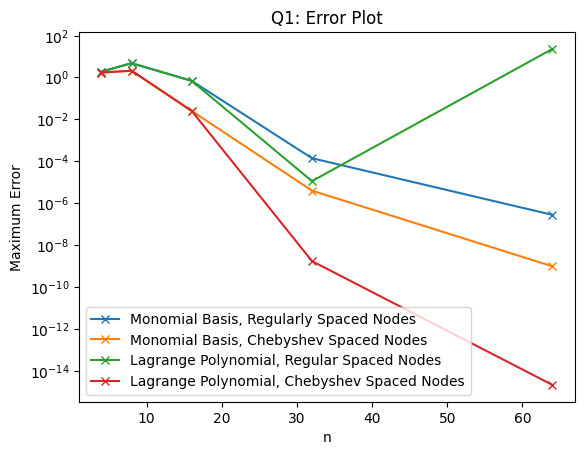

In [9]:
f = lambda x: np.sin(x) + np.sin(x**2)

interval = [0, 4]
n = np.logspace(2, 6, num=5, base=2, dtype=int)

x = np.linspace(*interval, num=1000)
f_true = f(x)

monomial_regular_nodes_err = []
monomial_regular_nodes_condition_number = []
monomial_chebyshev_nodes_err = []
monomial_chebyshev_nodes_condition_number = []
lagrange_regular_nodes_err = []
lagrange_chebyshev_nodes_err = []

for n_i in n:
    # Create regularly spaced nodes
    regular_nodes = np.linspace(*interval, num=n_i)
    chebyshev_nodes = generate_chebyshev_nodes(*interval, n_i)

    # Monomial basis, regular grid
    a, nu = monomial_interpolant(f, regular_nodes)
    err = np.linalg.norm(honer_evaluate(a, x) - f_true, np.inf)

    monomial_regular_nodes_err.append(err)
    monomial_regular_nodes_condition_number.append(nu)

    # Monomial basis, Chebyshev grid
    a, nu = monomial_interpolant(f, chebyshev_nodes)
    err = np.linalg.norm(honer_evaluate(a, x) - f_true, np.inf)

    monomial_chebyshev_nodes_err.append(err)
    monomial_chebyshev_nodes_condition_number.append(nu)

    # Lagrange Polynomial, regular grid
    err = np.linalg.norm(
        barycentric_interpolate(f(regular_nodes), regular_nodes, x) - f_true, np.inf
    )

    lagrange_regular_nodes_err.append(err)

    # Lagrange Polynomial, chebyshev grid
    err = np.linalg.norm(
        barycentric_interpolate(
            f(chebyshev_nodes), chebyshev_nodes, x, chebyshev=True
        )
        - f_true,
        np.inf,
    )

    lagrange_chebyshev_nodes_err.append(err)

# Plot error against the number of nodes
fig, ax = plt.subplots()
ax.plot(
    n,
    monomial_regular_nodes_err,
    "x-",
    label="Monomial Basis, Regularly Spaced Nodes",
)
ax.plot(
    n,
    monomial_chebyshev_nodes_err,
    "x-",
    label="Monomial Basis, Chebyshev Spaced Nodes",
)
ax.plot(
    n,
    lagrange_regular_nodes_err,
    "x-",
    label="Lagrange Polynomial, Regular Spaced Nodes",
)
ax.plot(
    n,
    lagrange_chebyshev_nodes_err,
    "x-",
    label="Lagrange Polynomial, Chebyshev Spaced Nodes",
)
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("n")
ax.set_ylabel("Maximum Error")
ax.set_title("Q1: Error Plot")
plt.show()

The monomial basis function with regular and Chebyshev points converges as
n increases. For the Lagrange polynomial with regular points as n increases the Runge phenomenon begins to dominate and
error diverges. The Lagrange polynomial with Chebyshev points converges faster than the monomial basis interpolant.

For the polynomial interpolant consisting of monomial basis functions, we can also plot the condition number of the Vandermonde matrix.

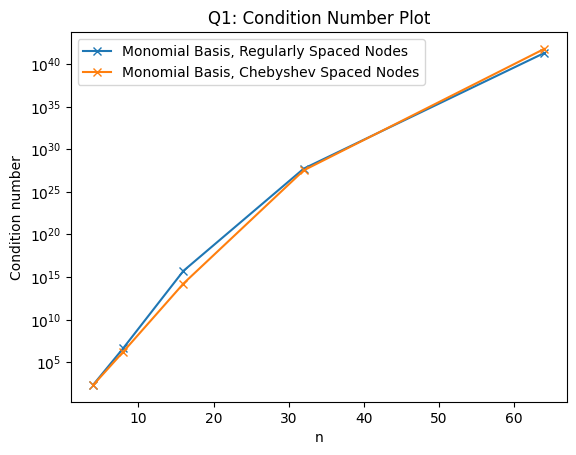

In [10]:
fig, ax = plt.subplots()
ax.plot(
    n,
    monomial_regular_nodes_condition_number,
    "x-",
    label="Monomial Basis, Regularly Spaced Nodes",
)
ax.plot(
    n,
    monomial_chebyshev_nodes_condition_number,
    "x-",
    label="Monomial Basis, Chebyshev Spaced Nodes",
)
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("n")
ax.set_ylabel("Condition number")
ax.set_title("Q1: Condition Number Plot")
plt.show()

Here we see that the condition number increases with the number of points. In fact, for even more points solving the system fails as the matrix becomes near singular.

# Question 2

Define function for linear spline interpolation.

In [11]:
from pna.interpolation import linear_spline_interpolate

%psource linear_spline_interpolate

def linear_spline_interpolate(f_i, x_i, x):
    """Compute and evaluate a linear spline interpolant"""
    if np.any(x < np.amin(x_i)) or np.any(x > np.amax(x_i)):
        raise ValueError("Cannot extrapolate")

    i = np.searchsorted(x_i, x)

    return ((x_i[i] - x) / (x_i[i] - x_i[i - 1])) * f_i[i - 1] + (
        (x - x_i[i - 1]) / (x_i[i] - x_i[i - 1])
    ) * f_i[i]


Then as before plot the error in interpolating $f$.

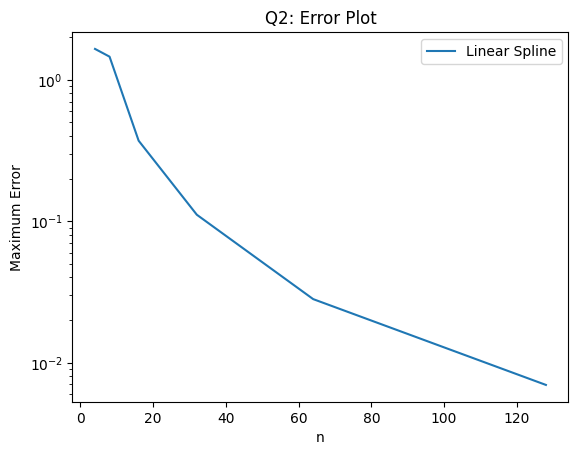

In [12]:
n = np.logspace(2, 7, num=6, base=2, dtype=int)

linear_spline_err = []

for n_i in n:
    xi = np.linspace(*interval, num=n_i)
    f_i = f(xi)

    err = np.linalg.norm(linear_spline_interpolate(f_i, xi, x) - f_true, np.inf)
    linear_spline_err.append(err)

fig, ax = plt.subplots()
ax.plot(n, linear_spline_err, label="Linear Spline")
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("n")
ax.set_ylabel("Maximum Error")
ax.set_title("Q2: Error Plot")
plt.show()

As expected the error decreases with more points. In fact we see the expected quadratic
convergent: as we increase n by an order of magnitude the error decreases by two
orders of magnitude.

# Question 3

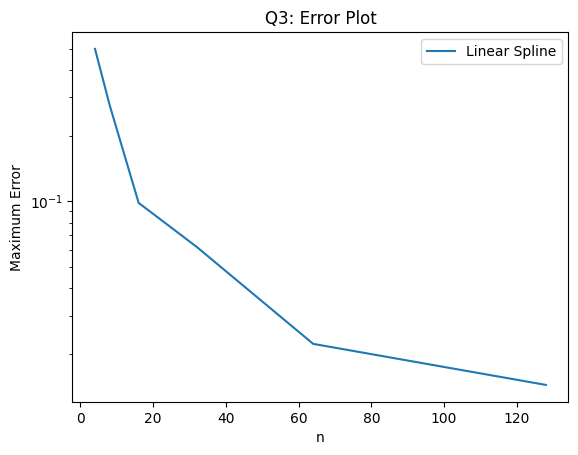

In [13]:
g = lambda x: np.abs(x - 1 / 3)
g_true = g(x)

linear_spline_err_g = []

for n_i in n:
    xi = np.linspace(*interval, num=n_i)
    g_i = g(xi)

    err = np.linalg.norm(linear_spline_interpolate(g_i, xi, x) - g_true, np.inf)
    linear_spline_err_g.append(err)

fig, ax = plt.subplots()
ax.plot(n, linear_spline_err_g, label="Linear Spline")
ax.set_yscale("log")
ax.legend()
ax.set_xlabel("n")
ax.set_ylabel("Maximum Error")
ax.set_title("Q3: Error Plot")
plt.show()

Here the error stops decreases very slowly as the interpolating function struggles
capture the sharp corner in g. There would need to be a knot at $x=1/3$ to approximate
this function better.

# Question 4: